# **Redes Neuronales - Data Science**
### Pigini Jeremias Gabriel

En este trabajo realizare una red neuronal, enfocada en regrecion linear, con las librerias de Tensorflow(Keras), para predecir precios de autos. El Dataset para el trabajo fue obtenido manualmente aplicando Beautiful. Se aplico web scraping en la pagina de mercado libre para extraer los datos necesarios manualmente.

## **Librerias a instalas para este proyecto**

In [266]:
from IPython.core.builtin_trap import BuiltinUndefined
import requests
import pandas as pd
from bs4 import BeautifulSoup
import requests
#from requests.api import requestfrom
from IPython.display import display, HTML
import numpy as np
import math
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import autoviz
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, StandardScaler

# **web scraping**

In [267]:
#Aplicacom web scrapi para extraer la informacion
#Creamos una formula para modificar el link a comveniencia
busqueda = input('¿Que desea buscar?')

r = requests.get('https://autos.mercadolibre.com.ar/autos_PriceRange_15000USD-40000USD_ITEM*CONDITION_2230581_NoIndex_True')

contenido = r.content

soup = BeautifulSoup(contenido, 'html.parser')

contenido

¿Que desea buscar?autos


b'\n<!DOCTYPE html>\n<html lang="es-AR">\n<head><link rel="preconnect" href="https://www.google-analytics.com"/><link rel="preconnect" href="https://www.google.com"/><link rel="preconnect" href="https://data.mercadolibre.com"/><link rel="preconnect" href="https://http2.mlstatic.com"/><link rel="preconnect" href="https://stats.g.doubleclick.net"/><link rel="preconnect" href="https://analytics.mercadolibre.com.ar"/><link rel="preconnect" href="https://analytics.mercadolibre.com"/><link rel="preconnect" href="https://www.google.com.ar"/><script type=\'text/javascript\' nonce="8chcLS9FS6ZI0i9e64cJAA==">window.NREUM||(NREUM={});NREUM.info = {"agent":"","beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"NRBR-766f4fb616d3a2368ce","applicationID":"1729522169","agentToken":null,"applicationTime":530.813222,"transactionName":"YlZQYEVZC0QEV0BZV1scd0xHSgBEFl5HH39wZx0bHQ==","queueTime":0,"ttGuid":"21630ced2bf665df"}; (window.NREUM||(NREUM={})).init={privacy:{cookies_enabled:tr

In [268]:
#Creamos variables para poder extraer toda la informacion deseada sin recorrer pagina a pagina
try:
  last_page = soup.find('li', {'class' : "andes-pagination__page-count"}).text
  last_page_modified = int(last_page.replace('de',''))
except:
  pass

Productos_array = []

for page in range(0, last_page_modified):
  result = requests.get('https://autos.mercadolibre.com.ar/{}_Desde_{}_ITEM*CONDITION_2230581_NoIndex_True#unapplied_filter_id%3Dprice%26unapplied_filter_name%3DPrecio%26unapplied_value_id%3D15000USD-40000USD%26unapplied_value_name%3DU%24S15.000+a+U%24S40.000%26unapplied_autoselect%3Dfalse'.format(busqueda.replace(' ',' '),(page+48)+1))
  content_pagination = result.content

  soup_pagination = BeautifulSoup(content_pagination, 'html.parser')

  alldivs = soup_pagination.find_all('div', {'class': 'andes-card'})

  for item in alldivs:
    data = {}
    data['name'] = item.find('h2', {'class': 'ui-search-item__title'}).text
    data['price'] = item.find('span',{'class': "andes-money-amount ui-search-price__part ui-search-price__part--medium andes-money-amount--cents-superscript"}).text
    attributes = item.find_all('li', {'class': 'ui-search-card-attributes__attribute'})
    if len(attributes) >= 2:
        data['year'] = attributes[0].text
        data['Km'] = attributes[1].text
    else:
        data['year'] = 'Year not found'
        data['Km'] = 'Km not found'
    Productos_array.append(data)

    print(len(Productos_array))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


# **Creamos el dataframe con las informacion obtenida del web scrapi**

In [269]:
#Creamos el DataFrame
df = pd.DataFrame(Productos_array)

Observamos que los datos en precio estan en 2 formatos, decidimos dividirlos y ver el comportamiento de ambos por separado y luego transformaremos los datos de un valor de moneda para concatenarlos y ver como trabaja el modelo.
Por lo tanto en este trabajo se trabajara con el mismo modelo de prediccion almenos 3 veces

In [270]:
# Crear dos DataFrames filtrados para separar los precios en U$S y los de ARG
df2 = df[df['price'].str.contains('U\S', case=False, na=False)]
df1 = df[~df['price'].str.contains('U\S', case=False, na=False)]

Visualizacon el primer dataframe y lo analizamos

In [271]:
df1

,name,price,year,Km
7,Audi A1 1.4 Ambition Tfsi 122cv,$9.800.000,2013,100.000 Km
8,Fiat Cronos 1.8 16v Precision At6,$10.300.000,2022,38.000 Km
17,Peugeot 3008 2.0 Gt-line Hdi Tiptronic,$23.500.000,2019,102.000 Km
19,Honda Hr-v 1.8 Ex-l 2wd Cvt,$16.000.000,2018,115.000 Km
20,Volkswagen Nivus 1.0 Tsi 170 Mt Confortline,$17.500.000,2022,37.000 Km
...,...,...,...,...
2010,Volkswagen Amarok 2.0 Cd Tdi 180cv 4x2 Trendline,$14.000.000,2021,128.000 Km
2012,Ford Ecosport 1.5 Titanium 123cv 4x2 Manual,$10.500.000,2018,93.000 Km
2013,Citro√´n C4 Lounge 1.6 Tendence Hdi 115cv,$8.300.000,2014,193.000 Km
2014,Chevrolet Onix 1.2,$9.500.000,2021,60.000 Km


In [272]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091 entries, 7 to 2015
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1091 non-null   object
 1   price   1091 non-null   object
 2   year    1091 non-null   object
 3   Km      1091 non-null   object
dtypes: object(4)
memory usage: 42.6+ KB


In [273]:
df1.describe()

,name,price,year,Km
count,1091,1091,1091,1091
unique,43,30,12,37
top,Volkswagen Amarok 3.0 V6 Cd Highline,$13.000.000,2016,108.000 Km
freq,81,88,202,83


In [274]:
df1.nunique()

name     43
price    30
year     12
Km       37
dtype: int64

Aun observamos que no poseemos nulos, el df tiene su informacion como objeto en tomas las columnas, tambien podemos observar que etiquetas en las columnas price y km.
A continuacion vamos a solucionar este inconveniente que presenta el df

In [275]:
#Retiramos la etiqueta en price
df1['price'] = df1['price'].str.replace('$', '')
#Retiramos la etiqueta en km
df1['Km'] = df1['Km'].str.replace('Km', '')
#Convertimos los kilomeros en datos numericos
df1['Km'] = df1['Km'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos los precios en datos numericos
df1['price'] = df1['price'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos los años en datos numericos
df1['year'] = df1['year'].astype(int)

<ipython-input-275-8ebc747e8077>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [276]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091 entries, 7 to 2015
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1091 non-null   object
 1   price   1091 non-null   int64 
 2   year    1091 non-null   int64 
 3   Km      1091 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 42.6+ KB


In [277]:
df1.describe()

,price,year,Km
count,1.091000e+03,1091.000000,1091.000000
mean,1.449918e+07,2017.744271,90835.013749
std,5.969829e+06,2.702641,41663.905379
min,6.500000e+06,2011.000000,28000.000000
25%,9.600000e+06,2016.000000,54000.000000
50%,1.350000e+07,2018.000000,87000.000000
75%,1.750000e+07,2020.000000,116000.000000
max,3.000000e+07,2022.000000,193000.000000


Ahora podemos observar que los datos tienen una mejor funcionalidad para nuestro proyecto

# **Realizamos graficos para lograr un entendimento mas claro de los datos**

In [278]:
#Representacion de cantidad de autos por kilometros
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['Km'], **{})
chart

In [279]:
#Representacion de cantidad de autos por año
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['year'], **{})
chart

In [280]:
#Relacion años con precios
def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_3, *['price', 'year'], **{})
chart

<Figure size 600x600 with 0 Axes>

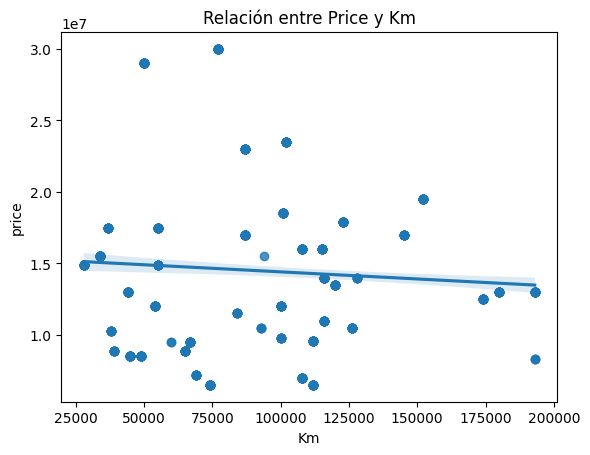

In [281]:
# Crear un gráfico de regresión para 'price' vs 'Km'
sns.regplot(data=df1, x='Km', y='price')
plt.title('Relación entre Price y Km')
plt.show()

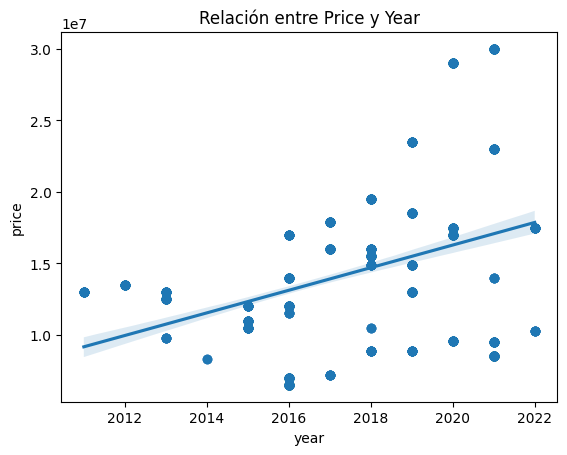

In [282]:
#Rrelacion precio y año del auto
sns.regplot(data=df1, x='year', y='price')
plt.title('Relación entre Price y Year')
plt.show()

In [283]:
#Representamos los quartiles y los outliers en casa de haber alguno
fig = px.box(df1['year'])
fig.show()

In [284]:
#Representamos los quartiles y los outliers en casa de haber alguno
fig = px.box(df1['price'])
fig.show()

In [285]:
#Representamos los quartiles y los outliers en casa de haber alguno
fig = px.box(df1['Km'])
fig.show()

<ipython-input-286-d4624a7a8914>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



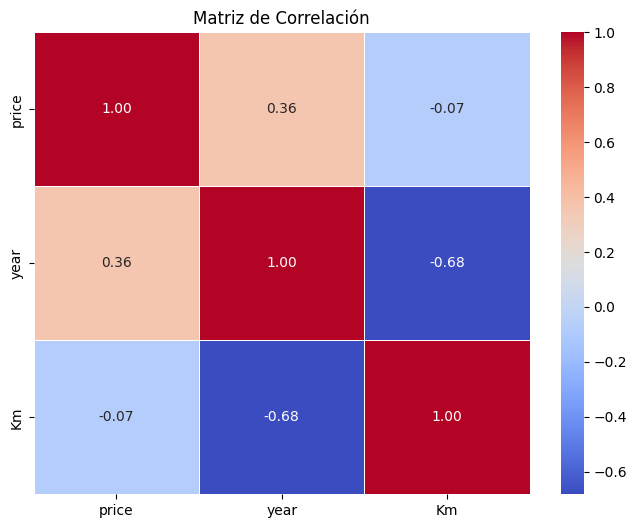

In [286]:
# Crear la matriz de correlación
correlation_matrix = df1.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

# **Observamos los datos en df2 y los analizamos**

In [287]:
df2

,name,price,year,Km
0,Volkswagen Amarok 2.0 Cd Tdi 180cv Comfortline...,U$S27.000,2021,22.100 Km
1,Bmw Serie 3 3.0 330i Sedan Sport Line 252cv,U$S33.500,2016,87.000 Km
2,Bmw Serie 1 1.6 120i M Package 177cv,U$S25.500,2017,135.700 Km
3,Fiat Strada 1.4 Working Cd,U$S14.200,2020,33.100 Km
4,Citro√´n Aircross 1.6 Vti 115 Urban Edition,U$S15.900,2019,23.600 Km
...,...,...,...,...
2001,Volkswagen Golf 1.4 Highline Tsi Dsg,U$S23.000,2020,69.000 Km
2002,Ford Ranger 3.2 Cd Xlt Tdci 200cv Autom√°tica 4x4,U$S36.900,2023,1.000 Km
2003,Audi Q5 2.0 Tfsi 211cv Stronic Quattro,U$S18.000,2012,111.000 Km
2004,Toyota Hilux 2.8 Cd Srx 177cv 4x4 At,U$S33.000,2020,73.000 Km


In [288]:
df2.nunique()

name     43
price    33
year     15
Km       41
dtype: int64

In [289]:
df2.describe()

,name,price,year,Km
count,925,925,925,925
unique,43,33,15,41
top,Volkswagen Golf 1.4 Highline Tsi Dsg,U$S28.000,2019,46.000 Km
freq,54,155,135,88


In [290]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 0 to 2011
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    925 non-null    object
 1   price   925 non-null    object
 2   year    925 non-null    object
 3   Km      925 non-null    object
dtypes: object(4)
memory usage: 36.1+ KB


**Observamos que los datos el df2 poseen el mismo problema que en df1, realizamos el mismo proceso**

In [291]:
#Eliminamos las etiquetas en Km
df2['Km'] = df2['Km'].str.replace('Km', '')
#Eliminamos las etiquetas en price
df2['price'] = df2['price'].str.replace(' U\$S', '').str.replace('U\$S', '')
#Convertimos las variables a numericas en price
df2['Km'] = df2['Km'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos las variables a numericas en Km
df2['price'] = df2['price'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos las variables a numericas en year
df2['year'] = df2['year'].astype(int)

<ipython-input-291-7db60c157f47>:4: FutureWarning:

The default value of regex will change from True to False in a future version.



In [292]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925 entries, 0 to 2011
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    925 non-null    object
 1   price   925 non-null    int64 
 2   year    925 non-null    int64 
 3   Km      925 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 36.1+ KB


In [293]:
df2.describe()

,price,year,Km
count,925.000000,925.000000,925.000000
mean,20794.486486,2016.708108,87267.675676
std,8320.441232,4.583425,60812.879057
min,7400.000000,2000.000000,1000.000000
25%,14000.000000,2015.000000,43000.000000
50%,22000.000000,2018.000000,75000.000000
75%,28000.000000,2019.000000,134000.000000
max,41500.000000,2023.000000,220000.000000


# **Graficamos df2 para tener un mejor entendimiento de los datos**

In [294]:
#Representacion de kilometros segun la cantidad de autos
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_13, *['Km'], **{})
chart

In [295]:
#Representacion de años segun la cantidad de autos
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_12, *['year'], **{})
chart

In [296]:
#Representacion de precios segun la cantidad de autos
def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_11, *['price'], **{})
chart

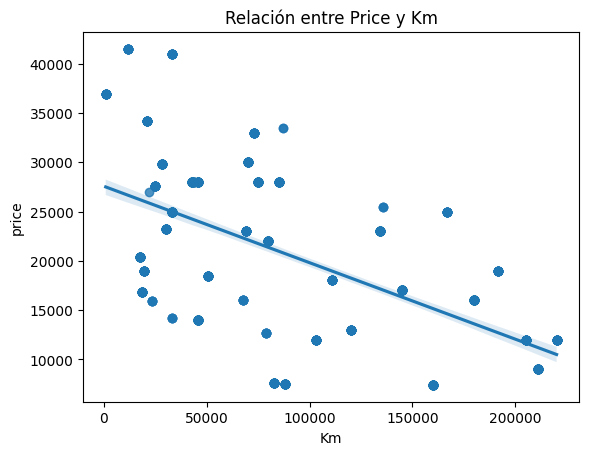

In [297]:
# Crear un gráfico de regresión para 'price' vs 'Km'
sns.regplot(data=df2, x='Km', y='price')
plt.title('Relación entre Price y Km')
plt.show()

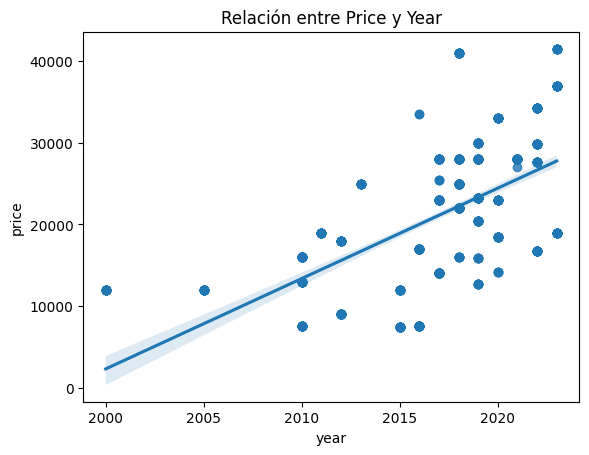

In [298]:
#Relacion entre precios y años
sns.regplot(data=df2, x='year', y='price')
plt.title('Relación entre Price y Year')
plt.show()

In [299]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df2['Km'])
fig.show()

In [300]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df2['price'])
fig.show()

In [301]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df2['year'])
fig.show()

<ipython-input-302-3d112db247e7>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



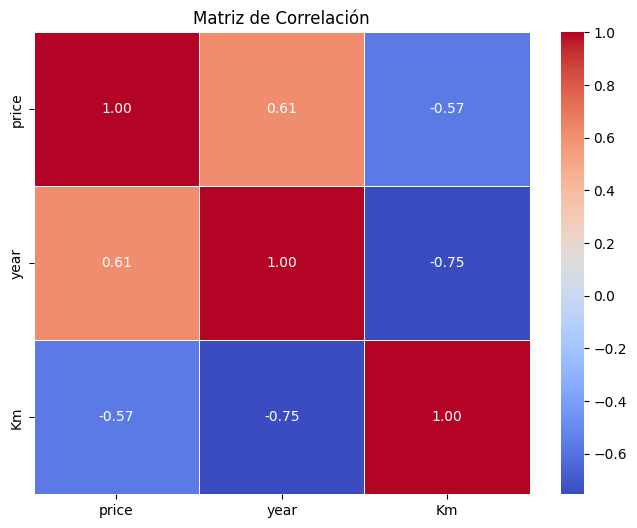

In [302]:
# Crear la matriz de correlación
correlation_matrix = df2.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

# **Realizamos One Hot**
realizamos one hot para volver la variable categorica name en numerica, creamos un nueva columna(id_name) para que cada variable distinta posea una etiquena numerica y al no eliminar 'name' podemos observar el auto que representa cada variable

In [303]:
df1 = df1.join(pd.get_dummies(df1['name'], prefix='name')).assign(id_name=lambda x: pd.factorize(x['name'])[0])

In [304]:
df1

,name,price,year,Km,name_Audi A1 1.4 Ambition Tfsi 122cv,name_Chevrolet Captiva 2.4 Ls Mt Fwd 167cv,name_Chevrolet Onix 1.2,name_Chevrolet Onix 1.4 Black Edition 1.4,name_Chevrolet Onix Plus 1.2 Lt,name_Chevrolet Prisma 1.4 Joy Ls,...,name_Volkswagen Amarok 2.0 Cd Tdi 180cv Comfortline At 4x4,name_Volkswagen Amarok 2.0 Cd Tdi 4x4 Highline Pack 1hp,name_Volkswagen Amarok 3.0 V6 Cd Highline,name_Volkswagen Golf 1.4 Comfortline Tsi,name_Volkswagen Golf 1.4 Comfortline Tsi Dsg,name_Volkswagen Golf 7 1.4 Comfortline Tsi Dsg,name_Volkswagen Nivus 1.0 Tsi 170 Mt Confortline,name_Volkswagen Sharan 2.0 Highline Tsi 200cv Dsg,name_Volkswagen Up! 1.0 Move Up! 75cv 3 P,id_name
7,Audi A1 1.4 Ambition Tfsi 122cv,9800000,2013,100000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Fiat Cronos 1.8 16v Precision At6,10300000,2022,38000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17,Peugeot 3008 2.0 Gt-line Hdi Tiptronic,23500000,2019,102000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
19,Honda Hr-v 1.8 Ex-l 2wd Cvt,16000000,2018,115000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
20,Volkswagen Nivus 1.0 Tsi 170 Mt Confortline,17500000,2022,37000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,Volkswagen Amarok 2.0 Cd Tdi 180cv 4x2 Trendline,14000000,2021,128000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37
2012,Ford Ecosport 1.5 Titanium 123cv 4x2 Manual,10500000,2018,93000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,38
2013,Citro√´n C4 Lounge 1.6 Tendence Hdi 115cv,8300000,2014,193000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,41
2014,Chevrolet Onix 1.2,9500000,2021,60000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,40


# **Realizamos la Red Neutonal de regrecion ineal aplicando Tensorflow-Keras**

Recordar que df1 posee el price en dolares

In [305]:
#seleccionamos las columnas a usar
df1 = df1[['id_name', 'year', 'price','Km','name']]

#Escalamos las variables de price para que el modelo lo reconosca mejor
scaler = StandardScaler()
df1['price'] = scaler.fit_transform(df1['price'].values.reshape(-1, 1))

#Dividimos el Dataset para realizar el entrenamiento
X = df1[['id_name','year','Km']].values
y = df1['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa el escalador
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define el modelo de red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1,),
])

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrena el modelo
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Evalúa el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')

# Hacer predicciones
predicciones = model.predict(X_test)

Epoch 1/2000
22/22 [==============================] - 1s 12ms/step - loss: 0.9339 - val_loss: 1.0116
Epoch 2/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.7853 - val_loss: 0.8603
Epoch 3/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.6857 - val_loss: 0.7685
Epoch 4/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.5908 - val_loss: 0.7064
Epoch 5/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.5282 - val_loss: 0.6577
Epoch 6/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.4752 - val_loss: 0.6086
Epoch 7/2000
22/22 [==============================] - 0s 5ms/step - loss: 0.4275 - val_loss: 0.6011
Epoch 8/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.3881 - val_loss: 0.5237
Epoch 9/2000
22/22 [==============================] - 0s 5ms/step - loss: 0.3478 - val_loss: 0.4701
Epoch 10/2000
22/22 [==============================] - 0s 4ms/step - loss: 0.3151 - val_loss: 0.399

**Graficamos loss**

Epoch 1/2000
22/22 [==============================] - 0s 6ms/step - loss: 7.5839e-06 - val_loss: 9.1885e-06
Epoch 2/2000
22/22 [==============================] - 0s 4ms/step - loss: 7.9155e-06 - val_loss: 1.2031e-05
Epoch 3/2000
22/22 [==============================] - 0s 4ms/step - loss: 5.1009e-06 - val_loss: 5.6506e-06
Epoch 4/2000
22/22 [==============================] - 0s 4ms/step - loss: 4.1652e-06 - val_loss: 2.4810e-06
Epoch 5/2000
22/22 [==============================] - 0s 6ms/step - loss: 2.0379e-06 - val_loss: 5.1125e-06
Epoch 6/2000
22/22 [==============================] - 0s 5ms/step - loss: 3.8630e-06 - val_loss: 3.1932e-06
Epoch 7/2000
22/22 [==============================] - 0s 4ms/step - loss: 2.3716e-06 - val_loss: 2.2844e-06
Epoch 8/2000
22/22 [==============================] - 0s 5ms/step - loss: 1.1787e-06 - val_loss: 1.1047e-06
Epoch 9/2000
22/22 [==============================] - 0s 4ms/step - loss: 1.6256e-06 - val_loss: 2.0538e-06
Epoch 10/2000
22/22 [=======

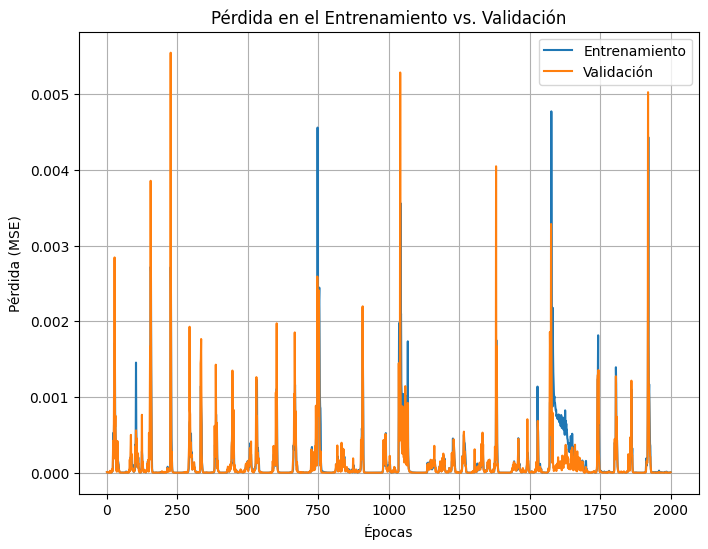

In [306]:
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Extraer la pérdida en el entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la pérdida en función del número de épocas
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida en el Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

# **Metricas para visualizar la efectividad del modelo**

### **Raíz del Error Cuadrático Medio (Root Mean Squared Error, RMSE)**
El RMSE es simplemente la raíz cuadrada del MSE y proporciona una medida de error en la misma escala que la variable objetivo. Cuanto menor sea el RMSE, mejor será el modelo.

In [307]:
from sklearn.metrics import mean_squared_error

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Raíz del Error Cuadrático Medio (RMSE): 0.0020087193407820622


### **Coeficiente de Determinación (R-cuadrado o R2)**
El R-cuadrado mide la proporción de la varianza en la variable objetivo que es explicada por el modelo. Un valor de R2 cercano a 1 indica un buen ajuste del modelo.

In [308]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicciones)
print(f'R^2: {r2}')

R^2: 0.999996352702955


### **Error Absoluto Medio (Mean Absolute Error, MAE)**
El MAE calcula el promedio de los valores absolutos de los errores entre las predicciones y los valores reales. Cuanto menor sea el MAE, mejor será el modelo.

In [309]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicciones)
print(f'MAE: {mae}')

MAE: 0.0015086500386483682


### **Error Cuadrático Medio (Mean Squared Error, MSE)**
El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales. Cuanto menor sea el MSE, mejor será el rendimiento del modelo.

In [310]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicciones)
print(f'MSE: {mse}')

MSE: 4.034953390031923e-06


# **Observamos como se comporta el modelo creado en df2**

Realizamos el mismo cambio en name que en df1

In [311]:
df2 = df2.join(pd.get_dummies(df2['name'], prefix='name')).assign(id_name=lambda x: pd.factorize(x['name'])[0])

Recordar que Price en df2 representa pesos ARG

In [312]:
#seleccionamos las columnas a usar
df2 = df2[['id_name', 'year', 'price','Km','name']]

#Escalamos las variables de price para que el modelo lo reconosca mejor
scaler = StandardScaler()
df2['price'] = scaler.fit_transform(df2['price'].values.reshape(-1, 1))

#Dividimos el Dataset para realizar el entrenamiento
X = df2[['id_name','year','Km']].values
y = df2['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa el escalador
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define el modelo de red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1,),
])

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrena el modelo
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Evalúa el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')

# Hacer predicciones
predicciones = model.predict(X_test)

Epoch 1/2000
19/19 [==============================] - 2s 13ms/step - loss: 0.9110 - val_loss: 0.7168
Epoch 2/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.7021 - val_loss: 0.6156
Epoch 3/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.5599 - val_loss: 0.5910
Epoch 4/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.4994 - val_loss: 0.5816
Epoch 5/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.4667 - val_loss: 0.5229
Epoch 6/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.4299 - val_loss: 0.4944
Epoch 7/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.4020 - val_loss: 0.4870
Epoch 8/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.3788 - val_loss: 0.4833
Epoch 9/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.3563 - val_loss: 0.4185
Epoch 10/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.3378 - val_loss: 0.398

### **Graficando la prediccion en funcion de la perdida**


Epoch 1/2000
19/19 [==============================] - 0s 11ms/step - loss: 4.6509e-06 - val_loss: 0.0290
Epoch 2/2000
19/19 [==============================] - 0s 6ms/step - loss: 4.9771e-06 - val_loss: 0.0290
Epoch 3/2000
19/19 [==============================] - 0s 6ms/step - loss: 5.8108e-06 - val_loss: 0.0290
Epoch 4/2000
19/19 [==============================] - 0s 6ms/step - loss: 5.3235e-06 - val_loss: 0.0290
Epoch 5/2000
19/19 [==============================] - 0s 6ms/step - loss: 5.1035e-06 - val_loss: 0.0291
Epoch 6/2000
19/19 [==============================] - 0s 6ms/step - loss: 6.7571e-06 - val_loss: 0.0291
Epoch 7/2000
19/19 [==============================] - 0s 5ms/step - loss: 5.4733e-06 - val_loss: 0.0291
Epoch 8/2000
19/19 [==============================] - 0s 4ms/step - loss: 8.4844e-06 - val_loss: 0.0290
Epoch 9/2000
19/19 [==============================] - 0s 5ms/step - loss: 8.9853e-06 - val_loss: 0.0290
Epoch 10/2000
19/19 [==============================] - 0s 5ms/s

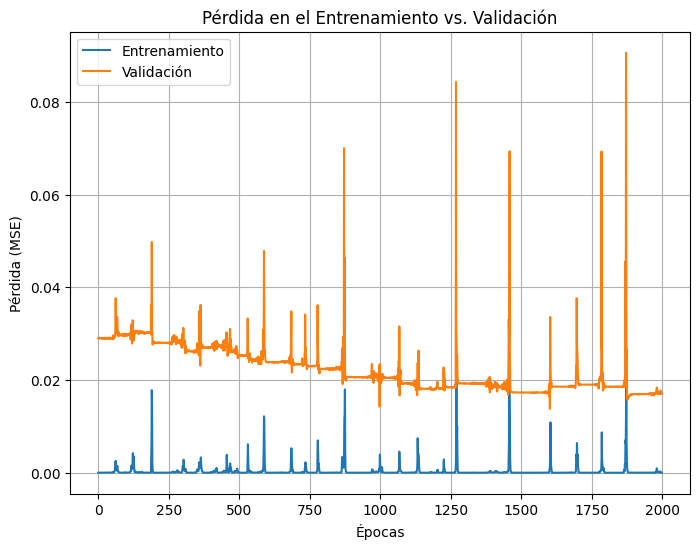

In [313]:
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Extraer la pérdida en el entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la pérdida en función del número de épocas
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida en el Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

### **Raíz del Error Cuadrático Medio (Root Mean Squared Error, RMSE)**
El RMSE es simplemente la raíz cuadrada del MSE y proporciona una medida de error en la misma escala que la variable objetivo. Cuanto menor sea el RMSE, mejor será el modelo.

In [314]:
from sklearn.metrics import mean_squared_error

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Raíz del Error Cuadrático Medio (RMSE): 0.1522871105758851


### **Coeficiente de Determinación (R-cuadrado o R2)**
El R-cuadrado mide la proporción de la varianza en la variable objetivo que es explicada por el modelo. Un valor de R2 cercano a 1 indica un buen ajuste del modelo.

In [315]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicciones)
print(f'R^2: {r2}')

R^2: 0.9775811265979835


### **Error Absoluto Medio (Mean Absolute Error, MAE)**
El MAE calcula el promedio de los valores absolutos de los errores entre las predicciones y los valores reales. Cuanto menor sea el MAE, mejor será el modelo.

In [316]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicciones)
print(f'MAE: {mae}')

MAE: 0.012493403672367303


### **Error Cuadrático Medio (Mean Squared Error, MSE)**
El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales. Cuanto menor sea el MSE, mejor será el rendimiento del modelo.

In [317]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicciones)
print(f'MSE: {mse}')

MSE: 0.023191364047551854


# **Ahora tranformaremos el Dataset que posee su 'price' como pesos argentinos a dolares US, concatenaremos ambos datasets y realizaremos una nueva prediccion**
Tomaremos como referencia que 1U$Sblue = 985arg, esto extraido del precio de mercado del dia 20/10/2023

Obtenemos la informacion cruda obtenida en un principio

In [348]:
df = pd.DataFrame(Productos_array)

Dividimos en dos dataframe con el objetivo de que la comvercion sea mas sencilla y luego concatenaremos

In [349]:
# Crear dos DataFrames filtrados
df2 = df[df['price'].str.contains('U\S', case=False, na=False)]
df1 = df[~df['price'].str.contains('U\S', case=False, na=False)]

Realizamos los cambios necesarios en df1

In [350]:
#Retiramos la etiqueta en price
df1['price'] = df1['price'].str.replace('$', '')
#Retiramos la etiqueta en km
df1['Km'] = df1['Km'].str.replace('Km', '')
#Convertimos los kilomeros en datos numericos
df1['Km'] = df1['Km'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos los precios en datos numericos
df1['price'] = df1['price'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos los años en datos numericos
df1['year'] = df1['year'].astype(int)

<ipython-input-350-8ebc747e8077>:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [351]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091 entries, 7 to 2015
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1091 non-null   object
 1   price   1091 non-null   int64 
 2   year    1091 non-null   int64 
 3   Km      1091 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 42.6+ KB


Realizamos los cambios necesarios en df2

In [352]:
df2

,name,price,year,Km
0,Volkswagen Amarok 2.0 Cd Tdi 180cv Comfortline...,U$S27.000,2021,22.100 Km
1,Bmw Serie 3 3.0 330i Sedan Sport Line 252cv,U$S33.500,2016,87.000 Km
2,Bmw Serie 1 1.6 120i M Package 177cv,U$S25.500,2017,135.700 Km
3,Fiat Strada 1.4 Working Cd,U$S14.200,2020,33.100 Km
4,Citro√´n Aircross 1.6 Vti 115 Urban Edition,U$S15.900,2019,23.600 Km
...,...,...,...,...
2001,Volkswagen Golf 1.4 Highline Tsi Dsg,U$S23.000,2020,69.000 Km
2002,Ford Ranger 3.2 Cd Xlt Tdci 200cv Autom√°tica 4x4,U$S36.900,2023,1.000 Km
2003,Audi Q5 2.0 Tfsi 211cv Stronic Quattro,U$S18.000,2012,111.000 Km
2004,Toyota Hilux 2.8 Cd Srx 177cv 4x4 At,U$S33.000,2020,73.000 Km


In [353]:
#Eliminamos las etiquetas en Km
df2['Km'] = df2['Km'].str.replace('Km', '')
#Eliminamos las etiquetas en price
df2['price'] = df2['price'].str.replace(' U\$S', '').str.replace('U\$S', '')
#Convertimos las variables a numericas en price
df2['Km'] = df2['Km'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos las variables a numericas en Km
df2['price'] = df2['price'].apply(lambda x: int(float(x.replace('.', ''))))
#Convertimos las variables a numericas en year
df2['year'] = df2['year'].astype(int)

<ipython-input-353-7db60c157f47>:4: FutureWarning:

The default value of regex will change from True to False in a future version.



**Realizamos la convercion de pesos a dolares**

In [354]:
# Definir la tasa de conversión
tasa_conversion = 1 / 985  # 1 dólar equivale a 985 pesos argentinos

# Aplicar la conversión directa
df1['price'] = df1['price'] * tasa_conversion
df1['price'] = df1['price'].astype(int)

## **Concatenamos los Dataframes**

In [355]:
df = pd.concat([df1, df2], ignore_index=True)

# **Graficamos para observar si se divisa un cambio drastico**

In [356]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df['Km'])
fig.show()

In [357]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df['price'])
fig.show()

In [358]:
#Representacion de quartiles y outliers en caso de encontrarse alguno
fig = px.box(df['year'])
fig.show()

<ipython-input-359-df3a28520d85>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



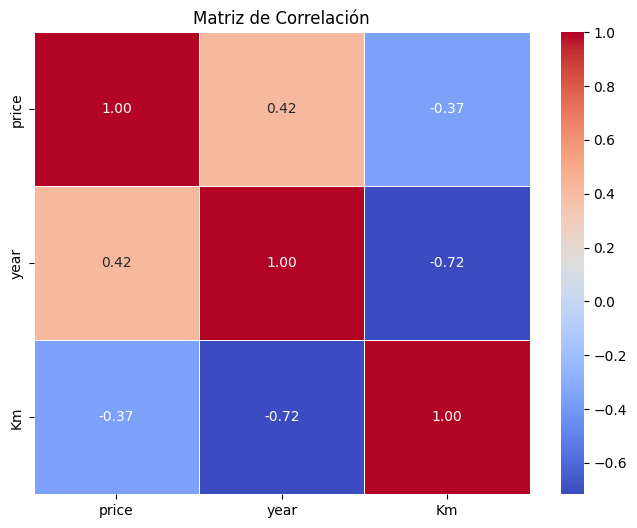

In [359]:
# Crear la matriz de correlación
correlation_matrix = df.corr()

# Crear un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Realizamos en encoded en name

In [360]:
df = df.join(pd.get_dummies(df2['name'], prefix='name')).assign(id_name=lambda x: pd.factorize(x['name'])[0])

# **Realizamos la ejecucion del modelo entrenado con el nuevo dataset concatenado**

In [361]:
#seleccionamos las columnas a usar
df = df[['id_name', 'year', 'price','Km','name']]

#Escalamos las variables de price para que el modelo lo reconosca mejor
scaler = StandardScaler()
df['price'] = scaler.fit_transform(df['price'].values.reshape(-1, 1))

#Dividimos el Dataset para realizar el entrenamiento
X = df[['id_name','year','Km']].values
y = df['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializa el escalador
scaler = StandardScaler()

# Ajusta el escalador a los datos de entrenamiento y transforma los datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define el modelo de red neuronal
model = keras.Sequential([
    keras.layers.Input(shape=(3,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1,),
])

# Compila el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrena el modelo
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Evalúa el modelo en el conjunto de prueba
loss = model.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {loss}')

# Hacer predicciones
predicciones = model.predict(X_test)

Epoch 1/2000
41/41 [==============================] - 1s 7ms/step - loss: 0.8886 - val_loss: 0.9011
Epoch 2/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.6983 - val_loss: 0.6870
Epoch 3/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.5641 - val_loss: 0.5925
Epoch 4/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.4923 - val_loss: 0.5207
Epoch 5/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.4220 - val_loss: 0.4443
Epoch 6/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.3756 - val_loss: 0.3788
Epoch 7/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.3417 - val_loss: 0.3483
Epoch 8/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.3159 - val_loss: 0.3335
Epoch 9/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.3034 - val_loss: 0.3609
Epoch 10/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.2778 - val_loss: 0.3109

### **Graficando la prediccion en funcion de la perdida**


Epoch 1/2000
41/41 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 2/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 3/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 4/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0110
Epoch 5/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 6/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 7/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 8/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 9/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/2000
41/41 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0017

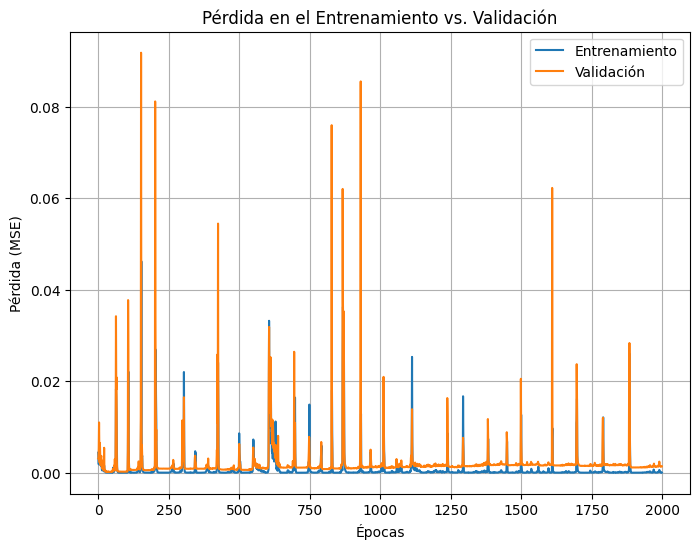

In [362]:
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.2)

# Extraer la pérdida en el entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de la pérdida en función del número de épocas
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Entrenamiento')
plt.plot(val_loss, label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida en el Entrenamiento vs. Validación')
plt.legend()
plt.grid(True)
plt.show()

### **Raíz del Error Cuadrático Medio (Root Mean Squared Error, RMSE)**
El RMSE es simplemente la raíz cuadrada del MSE y proporciona una medida de error en la misma escala que la variable objetivo. Cuanto menor sea el RMSE, mejor será el modelo.

In [363]:
from sklearn.metrics import mean_squared_error

# Calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Raíz del Error Cuadrático Medio (RMSE): 0.08789100803235037


### **Coeficiente de Determinación (R-cuadrado o R2)**
El R-cuadrado mide la proporción de la varianza en la variable objetivo que es explicada por el modelo. Un valor de R2 cercano a 1 indica un buen ajuste del modelo.

In [364]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicciones)
print(f'R^2: {r2}')

R^2: 0.9921614868052357


### **Error Absoluto Medio (Mean Absolute Error, MAE)**
El MAE calcula el promedio de los valores absolutos de los errores entre las predicciones y los valores reales. Cuanto menor sea el MAE, mejor será el modelo.

In [365]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicciones)
print(f'MAE: {mae}')

MAE: 0.025139491462765475


### **Error Cuadrático Medio (Mean Squared Error, MSE)**
El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales. Cuanto menor sea el MSE, mejor será el rendimiento del modelo.

In [366]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicciones)
print(f'MSE: {mse}')

MSE: 0.007724829292942676
